In [508]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sc
import io
import requests
import statsmodels.api as sm

url1 = "https://raw.githubusercontent.com/SzMatej/IAU_2020-2021/main/65/other_train.csv"
url2 = "https://raw.githubusercontent.com/SzMatej/IAU_2020-2021/main/65/personal_train.csv"

db1 = requests.get(url1).content
db2 = requests.get(url2).content
train = pd.read_csv(io.StringIO(db1.decode('utf-8')))
other = pd.read_csv(io.StringIO(db2.decode('utf-8')))

In [509]:
data = pd.merge(train,other,on=['name','address'], how = 'outer')

print(len(data))

3983


In [510]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0_x    3983 non-null   int64  
 1   name            3983 non-null   object 
 2   address         3983 non-null   object 
 3   race            3960 non-null   object 
 4   marital-status  3967 non-null   object 
 5   occupation      3962 non-null   object 
 6   pregnant        3969 non-null   object 
 7   education-num   3569 non-null   float64
 8   relationship    3967 non-null   object 
 9   capital-gain    3963 non-null   float64
 10  education       3968 non-null   object 
 11  fnlwgt          3965 non-null   float64
 12  class           3964 non-null   float64
 13  income          3968 non-null   object 
 14  medical_info    3965 non-null   object 
 15  native-country  3969 non-null   object 
 16  hours-per-week  3961 non-null   float64
 17  capital-loss    3968 non-null   f

### atribút pregnant

Upravíme boolean hodnoty v datasete tak že ich nahradíme číselnou reprezentáciou.
Taktiež nastavíme všetky hodnoty tohto atribútu u mužov na 0.

In [511]:
def sanitize_boolean(boolean):
    try:
        if boolean.strip() in ['f','F','FALSE','false','False']:
            return 0
        elif boolean.strip() in ['t','T','TRUE','true','True']:
            return 1
        else:
            return np.nan
    except AttributeError:
        return np.nan

In [512]:
data.pregnant = data.pregnant.map(sanitize_boolean)

In [513]:
def sanitize_pregnancy(data):
    data.loc[(data.sex == 1),'pregnant'] = 0
    return data

data = sanitize_pregnancy(data)

### atribút sex

Tento atribút neobsahuje žiadne prázdne hodnoty. Pri tomto atribúte treba len dané hodnoty prekonvertovať na numerické hodnoty.

In [514]:
data.sex.unique()

array([' Male', ' Female'], dtype=object)

In [515]:
def sanitize_sex(sex):
    return 1 if sex.strip() == 'Male' else 0

In [516]:
data.sex = data.sex.map(lambda sex: sanitize_sex(sex))

In [517]:
data.sex.unique()

array([1, 0], dtype=int64)

Hodnoty Male sme nahradili hodnotou 1 a naopak hodnotu female sme nahradili hodnotou 0

### atribút age

Pri tomto atribúte nahradíme záporné hodnoty na NaN. Takisto sa tu nachádzajú aj neznáme hodnoty ktoré sú reprezentované '??'. Tieto hodnoty taktiež nahradíme hodnotami NaN. Ďalej aby mali hodnoty jednotný dátový typ tak ich prekonvertujeme na numerickú hodnotu.

In [518]:
data.age.unique()

array(['53', '55', '65', '66', '37', '??', '42', nan, '57', '43', '56',
       '25', '45', '58', '86', '48', '54', '67', '46', '73', '71', '59',
       '64', '38', '62', '26', '70', '50', '52', '63', '61', '31', '30',
       '29', '74', '83', '41', '69', '75', '49', '27', '44', '51', '34',
       '60', '36', '40', '39', '15', '47', '20', '35', '32', '21', '68',
       '78', '77', '33', '28', '19', '80', '18', '81', '85', '17', '76',
       '9', '72', '7', '87', '24', '90', '3', '23', '79', '16', '22',
       '82', '84', '14', '113', '93', '-1', '12', '99'], dtype=object)

In [519]:
def sanitize_age(data):
    data.loc[(data.age == '-1'),'age'] = np.nan
    data.loc[(data.age == '??'),'age'] = np.nan
    return data

In [520]:
data = sanitize_age(data)

In [521]:
def sanitize_number(number):
    try:
        sanitized = int(pd.to_numeric(number, errors="coerce"))
        return sanitized if sanitized > 0 else np.nan
    except AttributeError:
        return np.nan
    except ValueError:
        return np.nan

In [522]:
data.age = data.age.map(lambda age: sanitize_number(age))

In [523]:
data.age.unique()

array([ 53.,  55.,  65.,  66.,  37.,  nan,  42.,  57.,  43.,  56.,  25.,
        45.,  58.,  86.,  48.,  54.,  67.,  46.,  73.,  71.,  59.,  64.,
        38.,  62.,  26.,  70.,  50.,  52.,  63.,  61.,  31.,  30.,  29.,
        74.,  83.,  41.,  69.,  75.,  49.,  27.,  44.,  51.,  34.,  60.,
        36.,  40.,  39.,  15.,  47.,  20.,  35.,  32.,  21.,  68.,  78.,
        77.,  33.,  28.,  19.,  80.,  18.,  81.,  85.,  17.,  76.,   9.,
        72.,   7.,  87.,  24.,  90.,   3.,  23.,  79.,  16.,  22.,  82.,
        84.,  14., 113.,  93.,  12.,  99.])

In [524]:
len(data[pd.isnull(data.age)])

400

Sem vidíme že pri tomto atribúte sa vyskytuje furt veľa chýbajúcich hodnôt (400). Toto sa dá vyriešiť niekoľkými spôsobmi. Buď vieme túto hodnotu nahradiť priemerom podľa jeho vekovej kategórie čo je lahší spôsob alebo vieme túto hodnotu dopočítať podľa jeho dátumu narodenia.

### atribút medical info

Pri tomto atribúte treba vyparsovať hodnoty jedného riadku a následne vytvoriť nové stĺpce do ktorých sa táto vyparsovaná hodnota doplní

In [525]:
data.medical_info.unique()

array(["{'mean_glucose':'111.8125','std_glucose':'44.88174566','kurtosis_glucose':'0.423867091','skewness_glucose':'0.239944007','mean_oxygen':'2.465719064','std_oxygen':'17.28981747','kurtosis_oxygen':'8.636118173','skewness_oxygen':'85.60462065'}",
       "{'mean_glucose':'71.3984375','std_glucose':'47.29517349','kurtosis_glucose':'1.317459045','skewness_glucose':'2.340411994','mean_oxygen':'17.114548499999998','std_oxygen':'46.86283003','kurtosis_oxygen':'3.070346153','skewness_oxygen':'9.405187883'}",
       "{'mean_glucose':'102.796875','std_glucose':'37.5346422','kurtosis_glucose':'0.382097319','skewness_glucose':'1.3556516','mean_oxygen':'2.706521739','std_oxygen':'19.87410184','kurtosis_oxygen':'7.955209532','skewness_oxygen':'67.64902246'}",
       ...,
       "{'mean_glucose':'129.90625','std_glucose':'48.62217818','kurtosis_glucose':'0.038773097','skewness_glucose':'-0.17251288','mean_oxygen':'3.319397993','std_oxygen':'22.72505413','kurtosis_oxygen':'8.750496392','skewness_

In [526]:
x = data['medical_info'].str.replace('{','').str.replace('\'','').str.split(',', expand=True)
i = 0
while i < len(x.columns):
    y = x[i].str.split(':', expand=True)
    data[y[0][0]] = y[1].astype(float)
    i += 2
data.drop('medical_info', axis='columns', inplace=True)

### atribút date of birth

Tento atribút nemá nejaký jednotný tvar, čiže je nutné to ošetriť

In [527]:
data.date_of_birth.unique()

array(['1966-05-16', '1964-06-29', '54-01-25', ..., '1988-09-29',
       '1958/12/17', '1959-09-29'], dtype=object)

In [528]:
def sanitize_date(date):
    date = str(date).replace('/', '-')
    date = date[:10]
    date = date.split("-")
    
    if date[0] != 'nan':
        if len(date[0]) != 4:
            if len(date[2]) == 2 and int(date[0]) > 31:
                new_date = "19"+ date[0] +"-"+date[1]+"-"+date[2] 
                
            elif ((len(date[2]) == 2) and (int(date[0]) < 31) and (int(date[2]) > 31)):
                new_date = "19"+date[2]+"-"+date[1]+"-"+date[0] 
                
            elif ((len(date[2]) == 2) and (int(date[0]) < 31) and (int(date[2]) < 31)):
                new_date = "20"+ date[2] + "-" +date[1]+"-" + date[0] 
            else:
                new_date = date[2]+"-"+date[1]+"-"+date[0] 
            return new_date        
    return '-'.join(date)

In [529]:
data.date_of_birth = data.date_of_birth.map(sanitize_date)
data.date_of_birth.head(10)

0    1966-05-16
1    1964-06-29
2    1954-01-25
3    1952-10-30
4    1982-01-13
5    1950-09-17
6    1976-11-25
7    1954-07-14
8    1954-07-14
9    1962-09-11
Name: date_of_birth, dtype: object

Teraz má tento atribúť jednotný tvar hodnôt. teraz môžme upraviť atribút age tak, že pomocou dátumu vypočítame chýbajúce hodnoty

In [530]:
len(data[pd.isnull(data.date_of_birth)])

0

Tu vidíme že pri stĺpci dátumu narodenia nechýbajú žiadne hodnoty tak by nemal byť problém s dopočítaním hodnôt pre stĺpec vek

In [531]:
years = [];

def find_measure_year(age, date_of_birth):
    if (pd.notnull(age)):
        years.append(int(date_of_birth.split('-')[0]) + int(age))
        
data.apply(lambda x: find_measure_year(x.age,x.date_of_birth), axis = 1)

measure_year = pd.Series(years).mode();

In [532]:
def fill_null_age(age,date):
    if (date):
        return (measure_year - int(date.split('-')[0]))[0]
    return np.nan

data.loc[data.age.isnull(),'age'] = data[data.age.isnull()].apply(lambda x: fill_null_age(x.age,x.date_of_birth),axis = 1)

In [533]:
len(data[pd.isnull(data.age)])

0

Ako je vidieť podarilo sa nám doplniť všetky hodnoty pri stĺpci age. Docielili sme to tak, že sme našli najviac vyskytujúci sa rok po sčítani veku a roku narodenia. Takto sme našli rok kedy sa uskutočnilo meranie, podľa ktorého sme ďalej našli roky chýbajúcich ľudí v datasete podľa dátumu narodenia.

In [534]:
data.age.unique()

array([ 53.,  55.,  65.,  66.,  37.,  69.,  42.,  57.,  43.,  56.,  25.,
        45.,  58.,  86.,  48.,  54.,  67.,  46.,  73.,  71.,  59.,  64.,
        38.,  62.,  26.,  70.,  50.,  52.,  63.,  61.,  51.,  31.,  30.,
        72.,  29.,  74.,  83.,  41.,  75.,  49.,  27.,  44.,  34.,  60.,
        36.,  40.,  39.,  32.,  15.,  47.,  68.,  20.,  35.,  21.,  78.,
        77.,  33.,  28.,  19.,  80.,  18.,  81.,  85.,  17.,  76.,   9.,
         7.,  87.,  24.,  90.,   3.,  23.,  79.,  16.,  97.,  22.,  82.,
        84.,  14., 113.,  93.,  -1.,  12.,  99.])

Po úprave vidíme že sa pri atrigúte age znova vyskytuje hodnota -1. To znamená len to, že sa v datasete vyskytujú aj niektoré zlé dátumy. Tieto hodnoty teda doplníme priemerom ako bolo spomenuté vyššie.

In [535]:
data.loc[(data.age < 0)].date_of_birth

3307    2020-04-06
Name: date_of_birth, dtype: object

Tu vidíme, že pri niektorých hodnotách je naozaj nastavený zlý dátum narodenia a to ten istý

In [536]:
median = data[(data.age > 0)].groupby('sex', as_index=False).age.mean()
data.loc[(data.age < 0), 'age'] = data[data.age < 0].age.map(lambda a: round(median.loc[0, 'age'], 0))

In [537]:
data['age'].describe()

count    3983.000000
mean       51.844590
std        11.783656
min         3.000000
25%        44.000000
50%        52.000000
75%        60.000000
max       113.000000
Name: age, dtype: float64

In [538]:
data.age.unique()

array([ 53.,  55.,  65.,  66.,  37.,  69.,  42.,  57.,  43.,  56.,  25.,
        45.,  58.,  86.,  48.,  54.,  67.,  46.,  73.,  71.,  59.,  64.,
        38.,  62.,  26.,  70.,  50.,  52.,  63.,  61.,  51.,  31.,  30.,
        72.,  29.,  74.,  83.,  41.,  75.,  49.,  27.,  44.,  34.,  60.,
        36.,  40.,  39.,  32.,  15.,  47.,  68.,  20.,  35.,  21.,  78.,
        77.,  33.,  28.,  19.,  80.,  18.,  81.,  85.,  17.,  76.,   9.,
         7.,  87.,  24.,  90.,   3.,  23.,  79.,  16.,  97.,  22.,  82.,
        84.,  14., 113.,  93.,  12.,  99.])

Tu boli nastavené všetky tieto neznáme hodnoty mediánom podľa pohlavia.

### atrbút income

Pri tomto atribúte tiež prekonvertujeme hodnoty na číselný tvar

In [539]:
data.income.unique()

array([' >50K', ' <=50K', nan], dtype=object)

In [540]:
data.income = data.income.map(lambda income: 0 if str(income).strip() == '<=50K' else 1 if str(income).strip() == '>50K' else np.nan)

In [541]:
data.income.unique()

array([ 1.,  0., nan])

### atribút Unnamed: 0_x

obsahuje poradové čísla, ktoré nepotrebujeme

In [542]:
print(data['Unnamed: 0_x'].unique())
data.drop('Unnamed: 0_x', axis='columns', inplace=True)

[   0    1    2 ... 3980 3981 3982]


### atribút Unnamed: 0_y

nevieme čo reprezentuje, zmažeme ho

In [543]:
print(data['Unnamed: 0_y'].unique())
data.drop('Unnamed: 0_y', axis='columns', inplace=True)

[3768 1089 3071 ... 3745 3735 2650]


### atribút fnlwgt

nevieme čo reprezentuje, zmažeme ho

In [544]:
print(data['fnlwgt'].unique())
data.drop('fnlwgt', axis='columns', inplace=True)

[270092.  34278. 107302. ... 217961.  75167. 202056.]


### stringove atribúty

In [545]:
def sanitize_string(string):
    try:
        string = string.strip()
        if string in ['None', 'nan', '??', '?']:
            return np.nan
        return string
    except AttributeError:
        return np.nan

### race

In [546]:
data['race'] = data['race'].map(sanitize_string)
data.race.value_counts()

White                 3359
Black                  398
Asian-Pac-Islander     133
Amer-Indian-Eskimo      42
Other                   28
Name: race, dtype: int64

Hodnota Asian-Pac-Islander a Amer-Indian-Eskimo reprezentujú rôzne rasy, tak ich dame do Other

In [547]:
data.race = data.race.map(lambda race: 'Other' if race in ('Asian-Pac-Islander', 'Amer-Indian-Eskimo') else race)

In [548]:
data.race.value_counts()

White    3359
Black     398
Other     203
Name: race, dtype: int64

### marital-status, relationship

Tieto atribúty reprezentujú podobné hodnoty, chceme ich počistit a zjednotiť

In [549]:
data['marital-status'] = data['marital-status'].map(sanitize_string)
data['relationship'] = data['relationship'].map(sanitize_string)

In [550]:
data['marital-status'].unique()

array(['Married-civ-spouse', 'Never-married', 'Separated', 'Divorced',
       'Married-spouse-absent', 'Widowed', nan, 'Married-AF-spouse'],
      dtype=object)

In [551]:
data['relationship'].unique()

array(['Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Own-child', nan,
       'Other-relative'], dtype=object)

Po analyze sme určili, že vo výslednom atribute relationship budú následujuce hodnoty: Not-Married, Married, Divorced/Widowed. Pri hodnotách, ako unmarried nevieme určit, či sú vo vzťahu, preto pouzivame výraz Not-Married..

In [552]:
def sanitize_relationship(relation):
    if relation in ('Married', 'Husband', 'Wife'):
        return 'Married'
    if relation in ('Not-Married', 'Not-in-family', 'Unmarried', 'Own-child', 'Other-relative'):
        return 'Not-Married'
    if relation == 'Divorced/Widowed':
        return relation
    return np.nan
def sanitize_marital_status(married):
    if married in ('Married', 'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'):
        return 'Married'
    if married in ('Not-Married', 'Never-married'):
        return 'Not-Married'
    if married in ('Separated', 'Divorced', 'Widowed'):
        return 'Divorced/Widowed'
    return married

In [553]:
data['relationship'] = data['marital-status'].map(sanitize_marital_status)
data['relationship'] = data['relationship'].map(sanitize_relationship)
data.drop('marital-status', axis='columns', inplace=True)

In [554]:
data['relationship'].unique()

array(['Married', 'Not-Married', 'Divorced/Widowed', nan], dtype=object)

### occupation, workclass

tu treba zjednotiť rovnaké názvy, rozdiely su iba v '_' a '-', a v začiatocných písmenách

In [555]:
def sanitize_work(string):
    try:
        return string.replace('-','_').capitalize()
    except AttributeError:
        return np.nan

In [556]:
data['occupation'] = data['occupation'].map(sanitize_string)
data['workclass'] = data['workclass'].map(sanitize_string)
data['occupation'] = data['occupation'].map(sanitize_work)
data['workclass'] = data['workclass'].map(sanitize_work)

In [557]:
data['occupation'].unique()

array(['Prof_specialty', 'Sales', 'Adm_clerical', 'Craft_repair',
       'Priv_house_serv', nan, 'Other_service', 'Exec_managerial',
       'Farming_fishing', 'Machine_op_inspct', 'Transport_moving',
       'Handlers_cleaners', 'Tech_support', 'Protective_serv',
       'Armed_forces'], dtype=object)

In [558]:
data['workclass'].unique()

array(['Private', 'Federal_gov', 'Self_emp_not_inc', nan, 'Self_emp_inc',
       'Local_gov', 'State_gov', 'Never_worked'], dtype=object)

### native-country

Hodnoty sú v poriadku, iba ich vyčistime a zmeníme neznáme hodnoty ('?') na nan

In [559]:
data['native-country'] = data['native-country'].map(sanitize_string)

In [560]:
data['native-country'].unique()

array(['United-States', nan, 'Poland', 'Hungary', 'Dominican-Republic',
       'El-Salvador', 'Mexico', 'Philippines', 'Italy', 'China', 'Laos',
       'Scotland', 'Canada', 'Germany', 'Taiwan', 'France', 'Vietnam',
       'England', 'Columbia', 'Cambodia', 'Iran', 'Puerto-Rico', 'Japan',
       'Haiti', 'Thailand', 'Nicaragua', 'Hong', 'Cuba', 'Greece',
       'Ecuador', 'Jamaica', 'South', 'Guatemala', 'India', 'Portugal',
       'Peru', 'Trinadad&Tobago', 'Ireland', 'Honduras', 'Yugoslavia'],
      dtype=object)

### odstránenie duplikátov

In [561]:
print('other lenght:',len(other))
print('personal lenght: ',len(train))
print('data lenght(spojený dataset): ',len(data))

other lenght: 3933
personal lenght:  3983
data lenght(spojený dataset):  3983


Tu môžme vidieť že tieto dva datasety nemajú rovnakú dĺžku a pritom by ju mali mať rovnakú. Tak v prvom rade odstránime možné duplikáty v spojenom datasete, ktorý sme spojili na začiatku. Odstraňovať ich budeme na základe mena, dátumu narodenia a adresy.

In [562]:
data = data.drop_duplicates(['name','address','date_of_birth'], keep="last")
print('data lenght(spojený dataset): ',len(data))

data lenght(spojený dataset):  3933


### pridanie chýbajúcich hodnôt

In [563]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

race                 11
occupation          254
pregnant              7
education-num       400
relationship          7
capital-gain         10
education            10
class                12
income                9
native-country       76
hours-per-week        9
capital-loss          7
workclass           249
mean_glucose          9
kurtosis_glucose      9
mean_oxygen           9
kurtosis_oxygen       9
dtype: int64

Sem vidíme, v ktorých stĺpcoch datasetu chýba koľko hodnôt. Na doplnenie týchto hodnot sa dá využit viacero ktoré využujeme (medián, knn, lineárna regresia).

### doplnenie hodnôt education-num

V prvej analýze sme zistili závislosť atribútov education a atribútov education-num, kde education-num je len čiselná reprezentácia stĺpca education. Čiže pri tomto atribúte nám stačí doplniť túto hodnotu podľa stĺpca education.

In [564]:
def get_education_num(education):
    temp = 10.0
    for i in data['education-num'].loc[data.education == education]:
        if (i > 0) & (i < temp):
            temp = i
    return temp


map = {}
for i in data.education.unique():
    map[i] = (get_education_num(i))
print(map)

{' Masters': 10.0, ' Some-college': 10.0, ' Bachelors': 10.0, ' HS-grad': 9.0, ' 7th-8th': 4.0, ' Assoc-voc': 10.0, ' Prof-school': 10.0, nan: 10.0, ' 11th': 7.0, ' 9th': 5.0, ' 10th': 6.0, ' Assoc-acdm': 10.0, ' 12th': 8.0, ' 5th-6th': 3.0, ' Doctorate': 10.0, ' 1st-4th': 2.0, ' Preschool': 1.0}


In [565]:
data.loc[:,'education-num'] = data.education.map(map)

In [566]:
print('Missing education-num: ', len(data[data['education-num'].isnull()]))
print('Missing education: ', len(data[data['education'].isnull()]))

Missing education-num:  0
Missing education:  10


Tieto hodnoty sa nám podarilo doplniť až nazopár hodnôt pri ktorých nie je uvedená ani hodnota education.

### doplnenie hodnôt mean_oxygen a kurtosis_glucose

<AxesSubplot:>

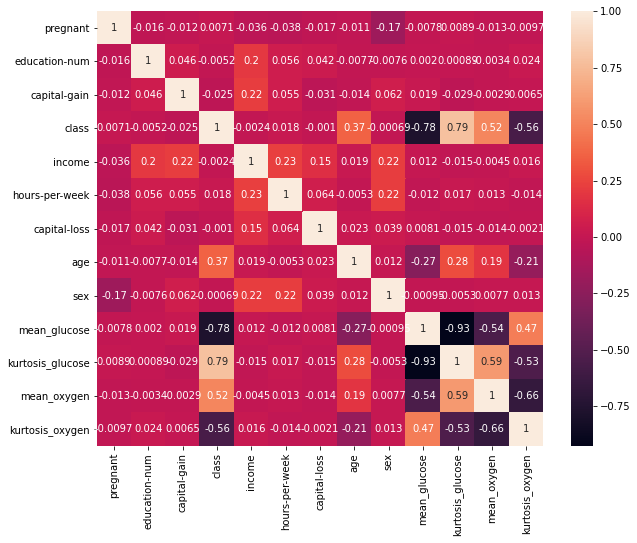

In [567]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data.corr(), ax=ax, annot=True)

po rozdelení tabuľky vidíme medzi týmito hodnotami koreláciu medzi nimi a zároveň tieto dva atribúty kolerujú s atribútmi age a class. Pre doplnenie týchto dvoch hodnôt použijeme knn metódu.

Atribút age už neobsahuje žiadne nulové hodnoty.

In [568]:
print(len(data[(data['kurtosis_glucose'].isnull()) & (data['mean_oxygen'].isnull()) & (data['class'].isnull())]))

2


In [569]:
print(len(data[(data['kurtosis_glucose'].isnull()) & (data['mean_oxygen'].isnull())]))

9


Tu vidíme že ak v riadku chýba hodnota kurtosis_glucose tak tam chýba aj hodnota mean_oxygen čiže jediné čo nám ostáva je dopočítať tieto hodnoty pomocou atribútu age a class.

Avšak v stĺpci class je takisto niekoľko nulových hodnôt (k tomu ešte pri dvoch riadkoch sú z týchto štyroch požadovaných hodnôt  tri neznáme). Tieto hodnoty v stĺpci class nemáme ako zistiť kedže nadobúda iba 3 hodnoty 1 (má cukrovku), 0 (nemá cukrovku) a nan. Preto riadky v ktorých sa nachádza hodnota nan v stĺpci class vymažeme.

In [570]:
def clear_nan(data):
    if data['class'].isnull().sum() > 0:
            data.dropna(subset=['class'], inplace=True)
    return data
            
data = clear_nan(data)

In [571]:
print(len(data[(data['class'].isnull())]))

0


Teraz sa v stĺpci class nenachádzajú žiadne nulové hodnoty

In [572]:
df = data[['kurtosis_glucose', 'mean_oxygen', 'age', 'class']]
df

,kurtosis_glucose,mean_oxygen,age,class
0,0.423867,2.465719,53.0,0.0
1,1.317459,17.114548,55.0,1.0
2,0.382097,2.706522,65.0,1.0
3,2.979318,159.611204,66.0,1.0
4,0.208886,6.483278,37.0,0.0
...,...,...,...,...
3978,3.385013,11.530936,67.0,1.0
3979,0.398672,2.050167,48.0,0.0
3980,0.038773,3.319398,31.0,0.0
3981,1.594315,14.135452,60.0,1.0


In [573]:
from sklearn.impute import KNNImputer

In [574]:
def replace_null_values_with_KNN_imputer(dataframe, no_of_neighbours):
    numpy_column = dataframe[['kurtosis_glucose', 'mean_oxygen', 'age']].to_numpy()
    numpy_column = np.reshape(numpy_column, (-1,3))

    class_column = dataframe['class'].to_numpy()
    class_column = np.reshape(numpy_column, (-1,1))

    
    imputer = KNNImputer(n_neighbors=no_of_neighbours, weights="uniform")
    numpy_column = imputer.fit_transform(numpy_column, class_column)
    return numpy_column

In [575]:
numpy_array = replace_null_values_with_KNN_imputer(df, 5)

In [576]:
data['kurtosis_glucose'] = numpy_array[:,[0]]
data['mean_oxygen'] = numpy_array[:,[1]]
data['age'] = numpy_array[:,[2]]

In [577]:
print(len(data[(data['kurtosis_glucose'].isnull())]))

0


In [578]:
print(len(data[(data['mean_oxygen'].isnull())]))

0


Chýbajúce hodnoty boli úspešne nahradené pomocou metódy knn

In [579]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

race                 8
occupation         251
pregnant             4
relationship         5
capital-gain         6
education            7
income               9
native-country      74
hours-per-week       8
capital-loss         5
workclass          246
mean_glucose         7
kurtosis_oxygen      7
dtype: int64

### doplnenie atribútu hours per week

Túto hodnotu sme sa rozhodli doplniť mediánom. Pri tomto atribúte by nahradenie mediánom mohlo byť asi najrozumnejšie. Táto hodnota ďalej koreluje s inými hodnotami a to využijeme pri dopĺňaní ďalších hodnôt.

In [580]:
data['hours-per-week'].fillna(round(data['hours-per-week'].mean(), 0), inplace=True)

In [581]:
print(len(data[(data['hours-per-week'].isnull())]))

0


Teraz sú hodnoty nan nahradené mediánom. Pre jednotnosť bola hodnota zaokrúhlená na 0 desatinných miest

### doplnenie atribútu income

Tento atribút koleruje s atribútom hours-per-week. Pre doplnenie chýbajúcich hodnôt sme sa preto rozhodli použiť lineárnu regresiu. 

In [582]:
data.income.unique()

array([ 1.,  0., nan])

In [583]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3921 entries, 0 to 3982
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3921 non-null   object 
 1   address           3921 non-null   object 
 2   race              3913 non-null   object 
 3   occupation        3670 non-null   object 
 4   pregnant          3917 non-null   float64
 5   education-num     3921 non-null   float64
 6   relationship      3916 non-null   object 
 7   capital-gain      3915 non-null   float64
 8   education         3914 non-null   object 
 9   class             3921 non-null   float64
 10  income            3912 non-null   float64
 11  native-country    3847 non-null   object 
 12  hours-per-week    3921 non-null   float64
 13  capital-loss      3916 non-null   float64
 14  workclass         3675 non-null   object 
 15  age               3921 non-null   float64
 16  sex               3921 non-null   int64  


In [584]:
from sklearn.linear_model import LinearRegression

regression = LinearRegression()
df = data[['hours-per-week','income']]
df2 = data[['hours-per-week','income']]
df.dropna(axis=0, how='any', inplace=True)
X = df['hours-per-week'].values.reshape(-1,1)

regression.fit(X, df['income'])
data_null = data['hours-per-week'].loc[(data['income'].isna()) & (~data['hours-per-week'].isna())]

temp = regression.predict(np.array(data_null).reshape(-1,1))
temp = [np.round(x, 0) for x in temp]

data['income'].loc[(data['income'].isna()) & (~data['hours-per-week'].isna())] = temp



<ipython-input-584-7ffb62db244b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, how='any', inplace=True)
c:\users\strak\virtual\env1\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [585]:
print(len(data[(data['income'].isnull())]))

0


Teraz je tento atribút vyriešený vypočítaním lineárnej regresie medzi týmtito atribútmi

In [586]:
data['income'].unique()

array([1., 0.])

In [587]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
cv = RepeatedStratifiedKFold(n_splits=15, n_repeats=300, random_state=1)

trans = KNNImputer(5, weights="uniform")
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[('t', trans), ('m', model)])


#df3.dropna(axis=0, how='any', inplace=True)
numpy_column = data[['income']].to_numpy()
numpy_column = np.reshape(numpy_column, (-1,1))

class_column = data[['hours-per-week']].to_numpy()
class_column = np.reshape(class_column, (-1,1))

n_scores = cross_val_score(pipeline, numpy_column, class_column, scoring='accuracy', cv=cv, n_jobs=-1)
# Výpis výkonu modelu (úspešnosti)
print('Presnosť transformácie, (štd. odchýlka): %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

c:\users\strak\virtual\env1\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass missing_values=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %

c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\

c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\

c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\

c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\

c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\

c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\

c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\

c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(("The least populated class in y has only %d"
c:\users\strak\virtual\env1\

Presnosť transformácie, (štd. odchýlka): 0.340 (0.172)


Sem vidíme, že koeficienty že koeficienty šikmosti a špicatosti sa po doplnení moc nezmenili a graf distribúcie sa zachoval čiže dopĺňanie hodnôt vyšlo celkom dobre.

### Attributy mean_glucose a kurtosis_oxygen
Hodnoty kurtosis_glucose a mean_glucose a hodnoty kurtosis_oxygen a mean_oxygen maju silnu negativnu korelaciu, takze mozeme pouzivat linearnu regresiu

In [588]:
regression = LinearRegression()
df = data[['kurtosis_glucose','mean_glucose']]
df2 = data[['kurtosis_glucose','mean_glucose']]
df.dropna(axis=0, how='any', inplace=True)
X = df['kurtosis_glucose'].values.reshape(-1,1)

regression.fit(X, df['mean_glucose'])
data_null = data['kurtosis_glucose'].loc[(data['mean_glucose'].isna()) & (~data['kurtosis_glucose'].isna())]

temp = regression.predict(np.array(data_null).reshape(-1,1))

data['mean_glucose'].loc[(data['mean_glucose'].isna()) & (~data['kurtosis_glucose'].isna())] = temp

<ipython-input-588-9c72f44a340e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, how='any', inplace=True)
c:\users\strak\virtual\env1\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [589]:
print(len(data[(data['mean_glucose'].isnull())]))

0


In [590]:
regression = LinearRegression()
df = data[['mean_oxygen','kurtosis_oxygen']]
df2 = data[['mean_oxygen','kurtosis_oxygen']]
df.dropna(axis=0, how='any', inplace=True)
X = df['mean_oxygen'].values.reshape(-1,1)

regression.fit(X, df['kurtosis_oxygen'])
data_null = data['mean_oxygen'].loc[(data['kurtosis_oxygen'].isna()) & (~data['mean_oxygen'].isna())]

temp = regression.predict(np.array(data_null).reshape(-1,1))

data['kurtosis_oxygen'].loc[(data['kurtosis_oxygen'].isna()) & (~data['mean_oxygen'].isna())] = temp

<ipython-input-590-5544a6d8bc1e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, how='any', inplace=True)
c:\users\strak\virtual\env1\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [591]:
print(len(data[(data['kurtosis_oxygen'].isnull())]))

0


### atrbúty capital_gain a capital_loss

Tieto atribúty taktiež kolerujú s atribútom income, ktorý sme už doplnili. Na doplnenie týchto atribútov použijeme knn metódu

In [592]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3921 entries, 0 to 3982
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3921 non-null   object 
 1   address           3921 non-null   object 
 2   race              3913 non-null   object 
 3   occupation        3670 non-null   object 
 4   pregnant          3917 non-null   float64
 5   education-num     3921 non-null   float64
 6   relationship      3916 non-null   object 
 7   capital-gain      3915 non-null   float64
 8   education         3914 non-null   object 
 9   class             3921 non-null   float64
 10  income            3921 non-null   float64
 11  native-country    3847 non-null   object 
 12  hours-per-week    3921 non-null   float64
 13  capital-loss      3916 non-null   float64
 14  workclass         3675 non-null   object 
 15  age               3921 non-null   float64
 16  sex               3921 non-null   int64  


In [593]:
def replace_null_values_with_KNN_imputer(dataframe, column, no_of_neighbours):
    numpy_column = dataframe[column].to_numpy()
    numpy_column = np.reshape(numpy_column, (-1,1))

    class_column = dataframe['income'].to_numpy()
    class_column = np.reshape(numpy_column, (-1,1))

    
    imputer = KNNImputer(n_neighbors=no_of_neighbours, weights="uniform")
    numpy_column = imputer.fit_transform(numpy_column, class_column)
    return numpy_column

In [594]:
df = data[['capital-loss', 'income']]
numpy_array = replace_null_values_with_KNN_imputer(df, 'capital-loss', 5)

In [595]:
data['capital-loss'] = numpy_array[:,[0]]
data['capital-loss'] = np.round(data['capital-loss'], 0)

In [596]:
data['capital-loss'].unique()

array([   0., 1902.,   86., 2415., 1651., 1672., 1977., 1887., 1980.,
       2174., 1408., 1485., 1740., 1564., 1876., 1258., 2258., 2559.,
       1602.,  213., 2001., 2377., 1848., 2444., 2002., 1668., 2042.,
       2163.,  625., 2392.,  419., 1590., 1741., 1721., 1825., 2051.,
       1719., 2339., 1974., 1380., 1092., 2057., 1579., 1944., 1617.,
       1340., 2472., 2246., 2179., 1726., 1138., 2467., 1628.])

In [597]:
print(len(data[(data['capital-loss'].isnull())]))

0


In [598]:
df = data[['capital-gain', 'income']]
numpy_array = replace_null_values_with_KNN_imputer(df, 'capital-gain', 5)

In [599]:
data['capital-gain'] = numpy_array[:,[0]]
data['capital-gain'] = np.round(data['capital-gain'], 0)

In [600]:
data['capital-loss'].unique()

array([   0., 1902.,   86., 2415., 1651., 1672., 1977., 1887., 1980.,
       2174., 1408., 1485., 1740., 1564., 1876., 1258., 2258., 2559.,
       1602.,  213., 2001., 2377., 1848., 2444., 2002., 1668., 2042.,
       2163.,  625., 2392.,  419., 1590., 1741., 1721., 1825., 2051.,
       1719., 2339., 1974., 1380., 1092., 2057., 1579., 1944., 1617.,
       1340., 2472., 2246., 2179., 1726., 1138., 2467., 1628.])

In [601]:
print(len(data[(data['capital-gain'].isnull())]))

0


### Zostavajuce attributy
Attributy race, pregnant, relationship, education maju malo nulovych hodnot a nemaju korelacie, tak ich nahradime najcastejsou hodnotou

In [602]:
data.race = data.race.fillna(data.race.value_counts().idxmax)
data.pregnant = data.pregnant.fillna(data.race.value_counts().idxmax)
data.relationship = data.relationship.fillna(data.race.value_counts().idxmax)
data.education = data.education.fillna(data.race.value_counts().idxmax)

In [603]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()
## tuto education-num sme riesili pred tym nie? potom tam chyba iba zostane  occupation a workclass
# tie su kategoricke attributy, takze bud tam dame random hodnoty, alebo zmazeme cele, alebo tam dame tu najcaste

occupation        251
native-country     74
workclass         246
dtype: int64